# Econ 212: Problem Set 3

In [1]:
from fredapi import Fred
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import numpy.linalg as la

In [2]:
fred = Fred(api_key = 'f6fa4f544be19c2ea791e9a3240470bf')

## Problem 1: Seignorage and inflation

## Problem 2: SVAR impulse response to monetary shocks

### Part A

In [3]:
real_GDP = fred.get_series('GDPC1', observation_start = '1959-01-01', observation_end = '2007-10-01')
price_deflator = fred.get_series('GDPDEF', observation_start = '1959-01-01', observation_end = '2007-10-01')
fed_funds_rate = fred.get_series('FEDFUNDS', observation_start = '1959-01-01', observation_end = '2007-12-01')

In [4]:
growth_rate = [400 * np.log(real_GDP[t] / real_GDP[t-1]) for t in range(1,len(real_GDP))]
inflation_rate = [400 * np.log(price_deflator[t] / price_deflator[t-1]) for t in range(1,len(price_deflator))]
fed_funds_rate = np.mean(np.reshape(fed_funds_rate, (3, len(fed_funds_rate) // 3), order = 'F'), axis = 0)[1:]

### Part B

### i

In [5]:
Xt = np.array([growth_rate, inflation_rate, fed_funds_rate])[:, 4:]
Xt1 = np.array([growth_rate, inflation_rate, fed_funds_rate])[:, 3:-1]
Xt2 = np.array([growth_rate, inflation_rate, fed_funds_rate])[:, 2:-2]
Xt3 = np.array([growth_rate, inflation_rate, fed_funds_rate])[:, 1:-3]
Xt4 = np.array([growth_rate, inflation_rate, fed_funds_rate])[:, :-4]

In [6]:
X = np.concatenate((Xt, Xt1, Xt2, Xt3)).T
X1 = np.concatenate((Xt1, Xt2, Xt3, Xt4)).T

In [7]:
A = (la.inv(X1.T @ X1) @ (X1.T @ X)).T

In [8]:
A1 = A[:3, :3]
A2 = A[:3, 3:6]
A3 = A[:3, 6:9]
A4 = A[:3, 9:]

In [9]:
Xt_hat = A1 @ Xt1 + A2 @ Xt2 + A3 @ Xt3 + A4 @ Xt4
eta_hat = Xt - Xt_hat

In [10]:
sigma_eta = (eta_hat @ eta_hat.T) / np.shape(eta_hat)[1]
H = la.cholesky(sigma_eta)

In [41]:
irf = [la.matrix_power(A.T, t)[:3, :3] @ H for t in range(15)]
irf = np.transpose(irf, (2, 0, 1))
irf = np.concatenate((irf[:][:][0], irf[:][:][1], irf[:][:][2]), axis = 1)

In [43]:
## Need to pull last 3 columns from IRF

# then plot irf

array([2.8673623 , 0.71332556, 1.19557099, 0.45150548, 0.69431438,
       0.47563484, 0.59805554, 0.31736349, 0.35842997, 0.30309536,
       0.32774589, 0.26601162, 0.2786401 , 0.25419777, 0.25717371])

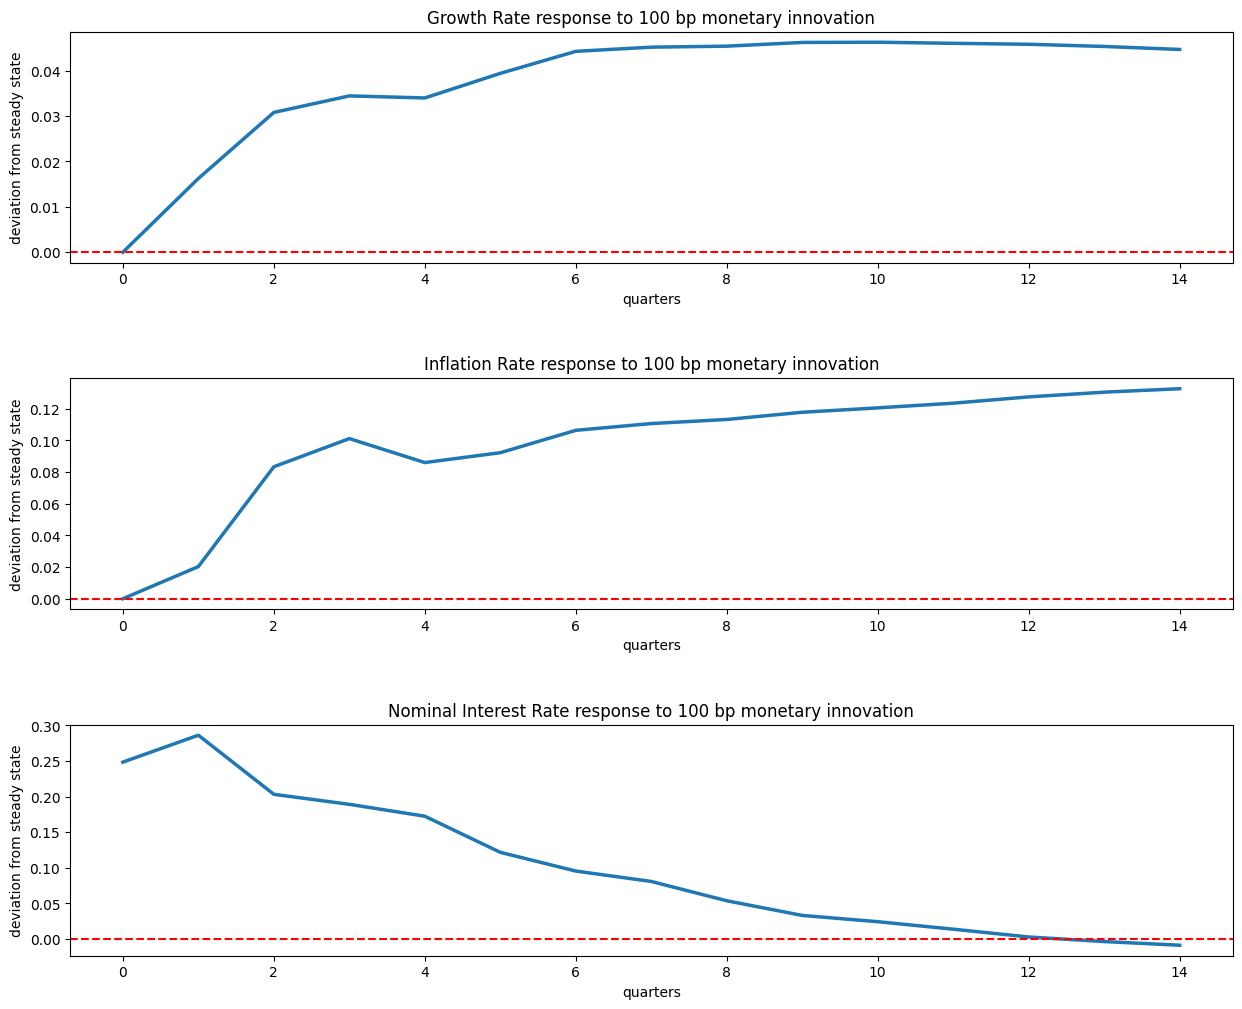

In [14]:
# compute IRF and scaled response function
sd_ff = np.std(fed_funds_rate)
shock = [0, 0, 1 / sd_ff]
var_list = ['Growth Rate','Inflation Rate', 'Nominal Interest Rate']

irf = [la.matrix_power(A.T, t)[:3, :3] @ H for t in range(15)]
response = [irf[t] @ shock for t in range(15)]

# plot
plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)

for i in range(np.shape(Xt)[0]):
    irf_series = [response[t][i] for t in range(15)]
    var = var_list[i]

    ax = plt.subplot(np.shape(Xt)[0], 1, i + 1)

    ax.plot(irf_series, linewidth = 2.5)
    ax.set_title(f'{var} response to 100 bp monetary innovation')
    ax.set_ylabel('deviation from steady state')
    ax.set_xlabel('quarters')
    ax.axhline(0, color = "r", linestyle = "--")
plt.show()

In [ ]:
X = [(growth_rate[t], inflation_rate[t], fed_funds_rate[t]) for t in range(len(inflation_rate))]
sd_ff = np.std(fed_funds_rate)
shock = [0, 0, 1 / sd_ff]
var_list = ['Growth Rate','Inflation Rate', 'Nominal Interest Rate']

In [ ]:
def plot_var_irf(X, periods, shock, var_list):
    # fit model
    model = VAR(X).fit(1, trend = 'n')
    
    # get L matrix
    b_gamma_inv = model.coefs
    sigma = np.cov(np.matrix(model.resid).T)
    L = la.cholesky(sigma).T

    # compute IRF and scaled response function
    irf = [(b_gamma_inv ** t) @ L for t in  range(periods)]
    response = [irf[t] @ shock for t in range(periods)]
    
    # plot
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for i in range(np.shape(X)[1]):
        irf_series = [response[t][0][i] for t in range(periods)]
        var = var_list[i]

        ax = plt.subplot(np.shape(X)[1], 1, i + 1)

        ax.plot(irf_series, linewidth=2.5)
        ax.set_title(f'{var} response to 100 bp monetary innovation')
        ax.set_ylabel('deviation from steady state')
        ax.set_xlabel('quarters')
        ax.axhline(0, color = "r", linestyle = "--")
    plt.show()

In [ ]:
plot_var_irf(X, 12, shock, var_list)

### ii

In [ ]:
X_permuted = [(inflation_rate[t], growth_rate[t], fed_funds_rate[t]) for t in range(len(inflation_rate))]
var_list_permuted = ['Inflation Rate','Growth Rate', 'Nominal Interest Rate']

plot_var_irf(X_permuted, 12, shock, var_list_permuted)

### iii

In [ ]:
total_reserves = np.log(fred.get_series('TOTRESNS', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])
m2 = np.log(fred.get_series('M2SL', observation_start = '1959-01-01', 
                                        observation_end = '2007-10-01')[::3])

In [ ]:
X_additional = [(growth_rate[t], inflation_rate[t], total_reserves[t], m2[t] ,fed_funds_rate[t]) 
                for t in range(len(fed_funds_rate))]

shock = [0,0,0,0,1/sd_ff]
var_list = ['Growth Rate','Inflation Rate','Log total reserves', 'Log M2', 'Nominal Interest Rate']

In [ ]:
plot_var_irf(X_additional, 12, shock, var_list)

In [ ]:
def compute_irf(X, periods, shock):
    model_boot = VAR(X).fit(1, trend = 'n')
            
    # get L matrix
    b_gamma_inv_boot = model_boot.coefs
    sigma_boot = np.cov(np.matrix(model_boot.resid).T)
    L_boot = la.cholesky(sigma_boot).T

    # compute IRF and scaled response function
    irf_boot = [(b_gamma_inv_boot ** t) @ L_boot for t in  range(periods)]
    response_boot = [irf_boot[t] @ shock for t in range(periods)]
    
    return(response_boot)

In [ ]:
def bootstrap_irf(X, K, periods, shock, var_list):
    # fit model
    model = VAR(X).fit(1, trend = 'n')
    
    # get L matrix
    b_gamma_inv = model.coefs
    sigma = np.cov(np.matrix(model.resid).T)
    L = la.cholesky(sigma).T

    # compute IRF and scaled response function
    irf = [(b_gamma_inv ** t) @ L for t in  range(periods)]
    response = [irf[t] @ shock for t in range(periods)]
    
    # residuals
    epsilons = model.resid
    
    # make some useful constants
    covs = np.shape(X)[1]
    n = np.shape(X)[0]
    
    # make 3 dimensional matrix to store irfs
    response_array = np.zeros((n, covs, K))
    
    for k in range(K):
        eps_boot = np.zeros((n, covs))

        for i in range(covs):
            eps_boot[:, i] = np.random.choice(epsilons[i, :], size = n, replace = True)

        X_boot = X @ b_gamma_inv + eps_boot
        response_array[:,:, k] = compute_irf(X_boot[0], periods, shock)[0]
        
    # plot
    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)

    for i in range(np.shape(X)[1]):
        irf_series = [response[t][0][i] for t in range(periods)]
        
        # get the 5th and 95th percentile outcomes        
        irf_upper_ci = [np.percentile(response_array[t][i], 97.5) for t in range(periods)]
        irf_lower_ci = [np.percentile(response_array[t][i], 2.5) for t in range(periods)]
    
        var = var_list[i]

        ax = plt.subplot(np.shape(X)[1], 1, i + 1)

        ax.plot(irf_series, linewidth=2.5)
        ax.plot(irf_upper_ci, linewidth = 2.5, color = "b")
        ax.plot(irf_lower_ci, linewidth = 2.5, color = "b")
        ax.set_title(f'{var} response to 100 bp monetary innovation')
        ax.set_ylabel('deviation from steady state')
        ax.set_xlabel('quarters')
        ax.axhline(0, color = "r", linestyle = "--")
    plt.show()

In [ ]:
bootstrap_irf(X, 10, 10, shock, var_list)